In [2]:
import sys 
sys.path.append("..")

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass 
from physics.fom import sensitivity, sfm, mcf, tsf 
from physics.reflectometry import _kz, reflectivity

from problems.base1 import Bounds, SOISpec, CapSpec, MRL, Materials, Base1OptimizationProblem, SubstrateSpec, MRL
from data.materials_loader import load_base1_materials

/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:68: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  # x_coti \in [0,1]
/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:124: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  - x_coti \in [bounds_x.lo, bounds_x.hi]


Sample $\theta \in \mathbb{R}^4$

In [4]:
# simple magnetic SLD model for now – tweak later if you want
def m_sld_from_x(x: float) -> float:
    return 1.0 * x  # placeholder linear scaling

materials = load_base1_materials("data.json", m_sld_from_x=m_sld_from_x)




In [5]:
from math import pi 

# Random test, will match with the paper when i get the data 
sois = [
    SOISpec("SOI1", rho_n=2.0, thickness=50.0, sigma=3.0),
   # SOISpec("SOI2", rho_n=2.0, thickness=80.0, sigma=3.0),
]

Q = np.linspace(0.005, 0.3, 400)

bounds_x = Bounds(0.0, 1.0)      # x_coti
bounds_d = Bounds(20.0, 300.0)   # d_mrl
bounds_cap = Bounds(5.0, 200.0)    # d_cap

# define problem: 

problem = Base1OptimizationProblem(
    materials=materials,
    soi_list=sois,
    q_grid=Q,
    bounds_x=bounds_x,
    bounds_d=bounds_d,
    bounds_cap=bounds_cap,
)
problem

In [6]:
space = problem.search_space
print(f"Params name: {space.names}")
print(f"dimensions: {len(space)}")

theta_raw = space.sample(5)   # (5, 3)
theta = np.vstack([space.clip(row) for row in theta_raw])  # clip each row

print("Raw samples:\n", theta_raw)
print("Clipped samples:\n", theta)

x0 = space.unpack(theta[0])   # first sample as dict
x0



Params name: ['x_coti', 'd_mrl', 'd_cap', 'cap']
dimensions: 4
Raw samples:
 [[3.89729078e-01 1.84601492e+02 1.17774858e+02 0.00000000e+00]
 [2.46575463e-01 2.55049780e+02 4.77637252e+01 2.00000000e+00]
 [1.68559124e-01 2.78972771e+02 1.34393591e+02 0.00000000e+00]
 [5.52486396e-01 1.87147337e+02 7.13773354e+01 1.00000000e+00]
 [9.45088073e-01 9.81309798e+01 1.36790354e+02 1.00000000e+00]]
Clipped samples:
 [[3.89729078e-01 1.84601492e+02 1.17774858e+02 0.00000000e+00]
 [2.46575463e-01 2.55049780e+02 4.77637252e+01 2.00000000e+00]
 [1.68559124e-01 2.78972771e+02 1.34393591e+02 0.00000000e+00]
 [5.52486396e-01 1.87147337e+02 7.13773354e+01 1.00000000e+00]
 [9.45088073e-01 9.81309798e+01 1.36790354e+02 1.00000000e+00]]


{'x_coti': 0.3897290776048611,
 'd_mrl': 184.60149225656454,
 'd_cap': 117.77485764736032,
 'cap': 'Al2O3'}

In [7]:
# Eval obj 

y0 = problem.evaluate_objective(
    x_coti=x0["x_coti"],
    d_mrl=x0["d_mrl"],
    cap=x0["cap"],   
    d_cap=x0["d_cap"],
)
y0

0.33777289063469995

mateirals -> layers -> reflectivity -> fom -> TSF 

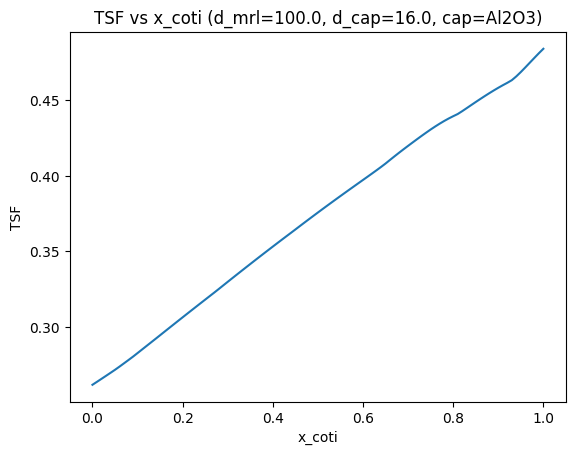

In [8]:
xs = np.linspace(bounds_x.lo, bounds_x.hi, 101)
ys = []

fixed_d_mrl = 100.0
fixed_d_cap = 16.0
fixed_cap = list(materials.caps.keys())[0]  # e.g. "Al2O3"

for x_coti in xs:
    ys.append(
        problem.evaluate_objective(
            x_coti=x_coti,
            d_mrl=fixed_d_mrl,
            cap=fixed_cap,
            d_cap=fixed_d_cap,
        )
    )

plt.plot(xs, ys)
plt.xlabel("x_coti")
plt.ylabel("TSF")
plt.title(f"TSF vs x_coti (d_mrl={fixed_d_mrl}, d_cap={fixed_d_cap}, cap={fixed_cap})")
plt.show()


## Small random search 


In [10]:
best_y = -np.inf 
best_x = None 


evals: int = 2000

for i in range(evals): 
    theta = space.clip(space.sample(1)[0])
    x = space.unpack(theta)

    y = problem.evaluate_objective(
        x_coti=x["x_coti"],
        d_mrl=x["d_mrl"], 
        cap=x["cap"],
        d_cap=x["d_cap"],
    )

    if y > best_y: 
        best_y = y
        best_x = x


print(f"best y: {best_y}")
print("--------------")
print(f"best x: {best_x}")

best y: 1.1154866419980123
--------------
best x: {'x_coti': 0.877247551559974, 'd_mrl': 198.64322360047174, 'd_cap': 194.73336703027937, 'cap': 'SiO2'}


# PLOT REFLECTICIY AND SENSTTIVITY FOR TESTIG 

In [4]:
import sys 
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass 

from physics.fom import sensitivity, sfm, mcf, tsf 
from physics.reflectometry import _kz, reflectivity

from problems.base1 import Bounds, SOISpec, CapSpec, MRL, Materials, Base1OptimizationProblem, SubstrateSpec
from data.materials_loader import load_base1_materials


/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:68: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  # x_coti \in [0,1]
/home/michaelbirtman/dev/Optimization-of-Magnetic-Reference-Layer/src/Notebooks/../problems/base1.py:124: SyntaxWarning: "\i" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\i"? A raw string is also an option.
  - x_coti \in [bounds_x.lo, bounds_x.hi]


In [5]:
def plot_grid(problem_fe, problem_coti, soi, x_fe=1.0, x_coti=0.73, d_mrl=100.0, bkg=1e-3):
    Q = problem_fe.Q

    fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey=True)

    row_labels = ["Without MRL", "Fe MRL", "CoTi MRL"]
    col_labels = ["No SOI", "With SOI"]

    # --- Row 0: without MRL (non-polarized) ---
    # No SOI
    layers = problem_fe.layers_no_mrl(soi=None)
    R = problem_fe._reflect(Q, layers, bkg=bkg)
    axes[0,0].semilogy(Q, R, label="Non-polarized")

    # With SOI
    layers = problem_fe.layers_no_mrl(soi=soi)
    R = problem_fe._reflect(Q, layers, bkg=bkg)
    axes[0,1].semilogy(Q, R, label="Non-polarized")

    # --- Row 1: Fe MRL ---
    # No SOI
    up, dn = problem_fe.layers_with_mrl(x_coti=x_fe, d_mrl=d_mrl, soi=None, cap="none", d_cap=0.0)
    R_up = problem_fe._reflect(Q, up, bkg=bkg)
    R_dn = problem_fe._reflect(Q, dn, bkg=bkg)
    axes[1,0].semilogy(Q, R_up, label="Spin-up")
    axes[1,0].semilogy(Q, R_dn, label="Spin-down")

    # With SOI
    up, dn = problem_fe.layers_with_mrl(x_coti=x_fe, d_mrl=d_mrl, soi=soi, cap="none", d_cap=0.0)
    R_up = problem_fe._reflect(Q, up, bkg=bkg)
    R_dn = problem_fe._reflect(Q, dn, bkg=bkg)
    axes[1,1].semilogy(Q, R_up, label="Spin-up")
    axes[1,1].semilogy(Q, R_dn, label="Spin-down")

    # --- Row 2: CoTi MRL ---
    # No SOI
    up, dn = problem_coti.layers_with_mrl(x_coti=x_coti, d_mrl=d_mrl, soi=None, cap="none", d_cap=0.0)
    R_up = problem_coti._reflect(Q, up, bkg=bkg)
    R_dn = problem_coti._reflect(Q, dn, bkg=bkg)
    axes[2,0].semilogy(Q, R_up, label="Spin-up")
    axes[2,0].semilogy(Q, R_dn, label="Spin-down")

    # With SOI
    up, dn = problem_coti.layers_with_mrl(x_coti=x_coti, d_mrl=d_mrl, soi=soi, cap="none", d_cap=0.0)
    R_up = problem_coti._reflect(Q, up, bkg=bkg)
    R_dn = problem_coti._reflect(Q, dn, bkg=bkg)
    axes[2,1].semilogy(Q, R_up, label="Spin-up")
    axes[2,1].semilogy(Q, R_dn, label="Spin-down")

    # Titles/labels
    for col, label in enumerate(col_labels):
        axes[0, col].set_title(label)

    for row, label in enumerate(row_labels):
        axes[row, 0].set_ylabel("Reflectivity (a.u.)")
        axes[row, 0].text(-0.18, 0.5, label, transform=axes[row, 0].transAxes,
                          rotation=90, va="center", ha="right")

    for ax in axes[-1, :]:
        ax.set_xlabel(r"Q ($\AA^{-1}$)")

    for ax in axes.ravel():
        ax.set_xlim(0.0, 0.06)
        ax.set_ylim(1e-3, 1.2)

    axes[1, 0].legend(loc="upper right")
    fig.tight_layout()
    plt.show()


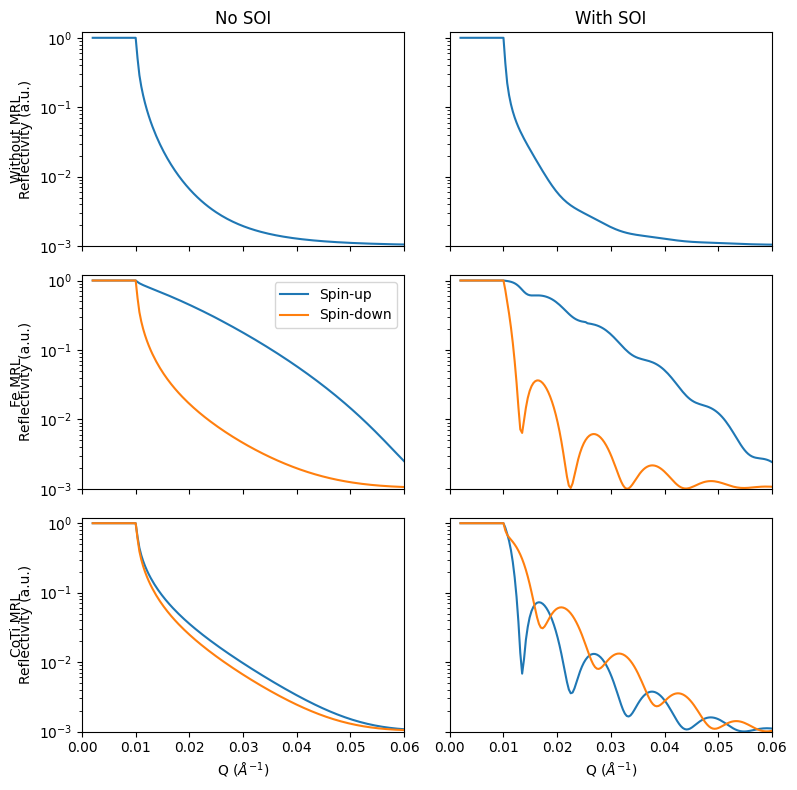

In [ ]:
# Q grid
Q = np.linspace(0.002, 0.28, 800)

# ---- substrate ----
substrate = SubstrateSpec(
    name="Si",
    rho_n=2.07e-6,   # Å^-2
    sigma=3.0        # Å
)

# ---- SOIs ----
sois: list[SOISpec] = [
    # normal, thickness 500 Å, sigma 15 Å
    SOISpec("normal_rho1", rho_n=1.0e-6, thickness=500.0, sigma=15.0),
    SOISpec("normal_rho2", rho_n=2.0e-6, thickness=500.0, sigma=15.0),
    SOISpec("normal_rho3", rho_n=3.0e-6, thickness=500.0, sigma=15.0),

    # rough, 500 Å, sigma 50 Å
    SOISpec("rough_rho1",  rho_n=1.0e-6, thickness=500.0, sigma=50.0),
    SOISpec("rough_rho2",  rho_n=2.0e-6, thickness=500.0, sigma=50.0),
    SOISpec("rough_rho3",  rho_n=3.0e-6, thickness=500.0, sigma=50.0),

    # thin, 50 Å, sigma 15 Å
    SOISpec("thin_rho1",   rho_n=1.0e-6, thickness=50.0,  sigma=15.0),
    SOISpec("thin_rho2",   rho_n=2.0e-6, thickness=50.0,  sigma=15.0),
    SOISpec("thin_rho3",   rho_n=3.0e-6, thickness=50.0,  sigma=15.0),
]

# convenience for just the "normal" SOIs in order ro = 1,2,3
normal_sois = sorted(
    [s for s in sois if s.name.startswith("normal_")],
    key=lambda s: s.rho_n
)
soi_normal_rho2 = [s for s in normal_sois if np.isclose(s.rho_n, 2e-6)][0]

# ---- MRLs ----

# CoTi MRL
rho_n_Co = 2.3e-6
rho_n_Ti = -1.9e-6
rho_m_Co = 3.9e-6  # mSLD for pure Co

def m_sld_from_x(x: float) -> float:
    # simple scaling with Co fraction
    return x * rho_m_Co

mrl_coti = MRL(
    rho_n_Co=rho_n_Co,
    rho_n_Ti=rho_n_Ti,
    m_sld_from_x=m_sld_from_x,
    sigma_sub_mrl=5.0,
    sigma_mrl_cap=5.0,
)

# Fe / Ni constant MRLs 
def make_constant_mrl(rho_n: float, rho_m: float) -> MRL:
    def m_const(x: float, rm=rho_m) -> float:
        return rm
    return MRL(
        rho_n_Co=rho_n,
        rho_n_Ti=rho_n,     # same => nuclear SLD independent of x
        m_sld_from_x=m_const,
        sigma_sub_mrl=5.0,
        sigma_mrl_cap=5.0,
    )

mrl_fe = make_constant_mrl(8.0e-6, 5.0e-6)
mrl_ni = make_constant_mrl(9.4e-6, 1.0e-6)

# ---- caps ----
caps = {
    "none":  CapSpec(name="none",  nom_thickness=0.0,  rho_n=0.0,   sigma=5.0),
    "Al2O3": CapSpec(name="Al2O3", nom_thickness=16.0, rho_n=4e-6,  sigma=5.0),
}

# ---- bounds for optimization variables ----
bounds_x = Bounds(0.0, 1.0)
bounds_d = Bounds(10.0, 200.0)
bounds_cap = Bounds(0.0, 40.0)

# ---- Materials & Base1 problems for each MRL ----
materials_fe = Materials(substrate=substrate, caps=caps, mrl=mrl_fe)
materials_ni = Materials(substrate=substrate, caps=caps, mrl=mrl_ni)
materials_coti = Materials(substrate=substrate, caps=caps, mrl=mrl_coti)

problem_fe = Base1OptimizationProblem(materials_fe, sois, Q, bounds_x, bounds_d, bounds_cap)
problem_ni = Base1OptimizationProblem(materials_ni, sois, Q, bounds_x, bounds_d, bounds_cap)
problem_coti = Base1OptimizationProblem(materials_coti, sois, Q, bounds_x, bounds_d, bounds_cap)



plot_grid(problem_fe, problem_coti, soi_normal_rho2, x_fe=1.0, x_coti=0.73, d_mrl=100.0, bkg=1e-3)